In this notebook we will be implementing karpathy's makemore lecture 6. And so here, part of the motivation is to increase the context length i.e. increase the number of characters that are being used to predict the next one in sequence.

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
# read in the sequences of demand profiles
data = open('../data/data.txt','r').read().splitlines()
data[:8]

['<M> <M> <M> <M> <M> <M> <M> <M> <M> <M> 1.0 2.0 4.0 4.0 4.0 1.0 1.0 1.0 1.0 2.0 1.0 2.0 1.0 1.0',
 '1.0 1.0 1.0 1.0 1.0 1.0 2.0 3.0 1.0 1.0 1.0 1.0 1.0 2.0 7.0 4.0 4.0 2.0 1.0 2.0 1.0 1.0 1.0 1.0',
 '1.0 1.0 1.0 1.0 1.0 2.0 1.0 3.0 6.0 1.0 1.0 1.0 1.0 1.0 1.0 4.0 8.0 2.0 2.0 2.0 2.0 1.0 1.0 1.0',
 '1.0 1.0 1.0 1.0 1.0 1.0 3.0 1.0 1.0 2.0 1.0 1.0 1.0 1.0 4.0 1.0 7.0 2.0 1.0 1.0 1.0 1.0 1.0 1.0',
 '1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0',
 '1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0',
 '1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 0.0 1.0 0.0 0.0 0.0',
 '1.0 1.0 1.0 1.0 1.0 1.0 1.0 0.0 0.0 1.0 0.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0']

In [3]:
# now we want to create the mapping from string to indices
chars = []
chars.append('<S>') # start token
# Define your order
order = ['0.0', '1.0', '2.0', '3.0', '4.0', '5.0', '6.0', '7.0', '8.0', '9.0', '10.0', '11.0', '12.0', '13.0', '14.0', '15.0', '16.0', '17.0', '18.0', '19.0', '20.0']
for i in order:
    chars.append(i)
chars.append('<M>') #<- missing token
chars.append('<E>') # end token
stoi = {s:i for i,s in enumerate(chars)}
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
itos

{0: '<S>',
 1: '0.0',
 2: '1.0',
 3: '2.0',
 4: '3.0',
 5: '4.0',
 6: '5.0',
 7: '6.0',
 8: '7.0',
 9: '8.0',
 10: '9.0',
 11: '10.0',
 12: '11.0',
 13: '12.0',
 14: '13.0',
 15: '14.0',
 16: '15.0',
 17: '16.0',
 18: '17.0',
 19: '18.0',
 20: '19.0',
 21: '20.0',
 22: '<M>',
 23: '<E>'}

In [4]:
# shuffle up the words
import random
random.seed(42)
random.shuffle(data)

In [8]:
# let's put this all together
block_size = 8 # this is the context length aka the number of characters we used to predict the next in sequence
# let's create the training, dev and test sets
def build_dataset(data):
    X, Y = [], []
    for s in data:
        #print(s)
        context = [0] * block_size
        for ch in s.split(' ') + ['<E>']:
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            #print(' '.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix] # crop and append
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(data)
n1 = int(0.8 * len(data))
n2 = int(0.9 * len(data))
Xtr, Ytr = build_dataset(data[:n1])
Xdev, Ydev = build_dataset(data[n1:n2])
Xte, Yte = build_dataset(data[n2:])

torch.Size([13475, 8]) torch.Size([13475])
torch.Size([1675, 8]) torch.Size([1675])
torch.Size([1700, 8]) torch.Size([1700])


In [9]:
for x,y in zip(Xtr[:20], Ytr[:20]):
  print(' '.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

<S> <S> <S> <S> <S> <S> <S> <S> --> 1.0
<S> <S> <S> <S> <S> <S> <S> 1.0 --> 0.0
<S> <S> <S> <S> <S> <S> 1.0 0.0 --> 2.0
<S> <S> <S> <S> <S> 1.0 0.0 2.0 --> 1.0
<S> <S> <S> <S> 1.0 0.0 2.0 1.0 --> 1.0
<S> <S> <S> 1.0 0.0 2.0 1.0 1.0 --> 1.0
<S> <S> 1.0 0.0 2.0 1.0 1.0 1.0 --> 1.0
<S> 1.0 0.0 2.0 1.0 1.0 1.0 1.0 --> 3.0
1.0 0.0 2.0 1.0 1.0 1.0 1.0 3.0 --> 1.0
0.0 2.0 1.0 1.0 1.0 1.0 3.0 1.0 --> 1.0
2.0 1.0 1.0 1.0 1.0 3.0 1.0 1.0 --> 1.0
1.0 1.0 1.0 1.0 3.0 1.0 1.0 1.0 --> 0.0
1.0 1.0 1.0 3.0 1.0 1.0 1.0 0.0 --> 0.0
1.0 1.0 3.0 1.0 1.0 1.0 0.0 0.0 --> 1.0
1.0 3.0 1.0 1.0 1.0 0.0 0.0 1.0 --> 0.0
3.0 1.0 1.0 1.0 0.0 0.0 1.0 0.0 --> 1.0
1.0 1.0 1.0 0.0 0.0 1.0 0.0 1.0 --> 3.0
1.0 1.0 0.0 0.0 1.0 0.0 1.0 3.0 --> 2.0
1.0 0.0 0.0 1.0 0.0 1.0 3.0 2.0 --> 6.0
0.0 0.0 1.0 0.0 1.0 3.0 2.0 6.0 --> 9.0


In [10]:
# Near copy paste of the layers we have developed in Part 3

# -----------------------------------------------------------------------------------------------
class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # note: kaiming init
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

# -----------------------------------------------------------------------------------------------
class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      if x.ndim == 2:
        dim = 0
      elif x.ndim == 3:
        dim = (0,1)
      xmean = x.mean(dim, keepdim=True) # batch mean
      xvar = x.var(dim, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

# -----------------------------------------------------------------------------------------------
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

# -----------------------------------------------------------------------------------------------
class Embedding:
  
  def __init__(self, num_embeddings, embedding_dim):
    self.weight = torch.randn((num_embeddings, embedding_dim))
    
  def __call__(self, IX):
    self.out = self.weight[IX]
    return self.out
  
  def parameters(self):
    return [self.weight]

# -----------------------------------------------------------------------------------------------
class FlattenConsecutive:
  
  def __init__(self, n):
    self.n = n
    
  def __call__(self, x):
    B, T, C = x.shape
    x = x.view(B, T//self.n, C*self.n)
    if x.shape[1] == 1:
      x = x.squeeze(1)
    self.out = x
    return self.out
  
  def parameters(self):
    return []

# -----------------------------------------------------------------------------------------------
class Sequential:
  
  def __init__(self, layers):
    self.layers = layers
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out
  
  def parameters(self):
    # get parameters of all layers and stretch them out into one list
    return [p for layer in self.layers for p in layer.parameters()]

In [11]:
torch.manual_seed(42); # seed rng for reproducibility

In [33]:
# original network
# n_embd = 10 # the dimensionality of the character embedding vectors
# n_hidden = 300 # the number of neurons in the hidden layer of the MLP
# model = Sequential([
#   Embedding(vocab_size, n_embd),
#   FlattenConsecutive(8), Linear(n_embd * 8, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#   Linear(n_hidden, vocab_size),
# ])

# hierarchical network
n_embd = 24 # the dimensionality of the character embedding vectors
n_hidden = 128 # the number of neurons in the hidden layer of the MLP
model = Sequential([
  Embedding(vocab_size, n_embd),
  FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, vocab_size),
])

# parameter init
with torch.no_grad():
  model.layers[-1].weight *= 0.1 # last layer make less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

76120


In [34]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update: simple SGD
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/ 200000: 3.1587
  10000/ 200000: 0.7860
  20000/ 200000: 1.0771
  30000/ 200000: 0.4780
  40000/ 200000: 0.4158
  50000/ 200000: 1.0279
  60000/ 200000: 0.5330
  70000/ 200000: 0.3254
  80000/ 200000: 0.7676
  90000/ 200000: 0.7786
 100000/ 200000: 0.4121
 110000/ 200000: 0.6428
 120000/ 200000: 0.6081
 130000/ 200000: 0.3786
 140000/ 200000: 0.4038
 150000/ 200000: 0.6509
 160000/ 200000: 0.3531
 170000/ 200000: 0.4651
 180000/ 200000: 0.6124
 190000/ 200000: 0.6550


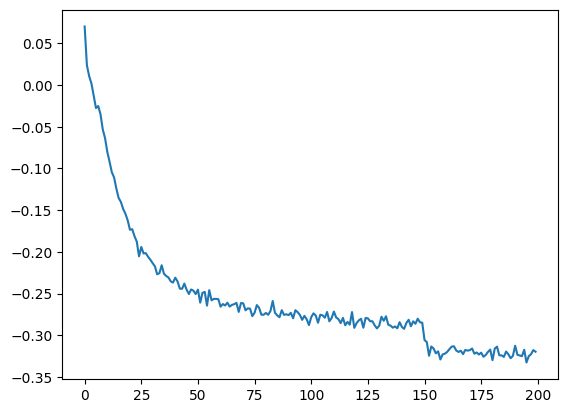

In [35]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [36]:
# put layers into eval mode (needed for batchnorm especially)
for layer in model.layers:
  layer.training = False

In [37]:
# evaluate the loss
@torch.no_grad() # this decorator disables gradient tracking inside pytorch
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 0.48456045985221863
val 1.719918966293335


# initial net
train 1.000532865524292
val 1.394815444946289

# after dampening the W2 and b2 (fix softmax confidently wrong)
train 1.0001459121704102
val 1.2435673475265503

# after dampening W1 and B1 (fix tanh saturation)
train 1.000976800918579
val 1.2172609567642212

# after using the kaiming init 
train 1.0001680850982666
val 1.2211095094680786

# with batchnorm layer
train 1.0072804689407349
val 1.1897488832473755

# with batchnorm and calibrated bnmean and bnstd
train 1.0072836875915527
val 1.1784292459487915

# with batchnorm and running bnmean and bnstd
train 1.0074577331542969
val 1.1806522607803345

# with 2 layer MLP with batchnorm, and block_size 8 rather than 3
train 0.49097272753715515
val 1.5978569984436035 
Clearly, overfitting. 

# with hierarchical layers with approx same num parameters as before ~30k
train 0.49277666211128235
val 1.6888234615325928
Slightly worse performance on the val, but similar to the train loss.

# with hierarchical and scaled up 72k parameters
train 0.48456045985221863
val 1.719918966293335
Lower train loss, but higher val loss even more overfitting. We're basically memorising the training data. 

In [23]:
for _ in range (20):
    out = [] 
    context = [0] * block_size
    while True:
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, 1)
        ix = torch.multinomial(probs, 1).item()
        out.append(ix)
        context = context[1:] + [ix]
        if itos[out[-1]] == '<E>':
            break
    print(' '.join(itos[i] for i in out))

1.0 1.0 1.0 1.0 1.0 1.0 1.0 2.0 2.0 2.0 1.0 2.0 2.0 2.0 3.0 3.0 1.0 1.0 2.0 <E>
1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 2.0 1.0 3.0 3.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 0.0 1.0 1.0 0.0 1.0 1.0 1.0 1.0 1.0 1.0 0.0 1.0 1.0 1.0 1.0 1.0 4.0 1.0 5.0 1.0 1.0 1.0 <E>
1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 2.0 1.0 1.0 5.0 2.0 5.0 1.0 1.0 1.0 1.0 3.0 2.0 6.0 1.0 1.0 1.0 2.0 2.0 10.0 9.0 3.0 1.0 1.0 1.0 1.0 <E>
0.0 1.0 0.0 0.0 1.0 1.0 1.0 1.0 1.0 1.0 <E>
1.0 1.0 1.0 1.0 1.0 1.0 2.0 2.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 3.0 2.0 5.0 1.0 2.0 1.0 1.0 <E>
2.0 1.0 1.0 1.0 1.0 1.0 1.0 4.0 2.0 2.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 4.0 5.0 2.0 7.0 1.0 7.0 3.0 3.0 2.0 1.0 1.0 1.0 <E>
1.0 1.0 1.0 1.0 1.0 1.0 1.0 2.0 1.0 1.0 2.0 4.0 3.0 2.0 1.0 1.0 <E>
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 2.0 2.0 1.0 1.0 1.0 1.0 1.0 1.0 0.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 <E>
1.0 1.0 1.0 1.0 1.0 1.0 2.0 1.0 1.0 2.0 2.0 1.0 3.0 2.0 1.0 8.0 2.0 2.0 1.0 1.0 3.0 5.0 3.0 2.0 6.0